In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import nltk
from  nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import json
import seaborn as sns
import requests
import statsmodels.formula.api as smf
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/youssefamine/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [45]:
PATH = 'cmu/'
movies = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movies = movies.dropna(subset=['Movie name', 'Movie box office revenue'])


characters = pd.read_csv(PATH + 'character.metadata.tsv', sep='\t', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date', 'Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']

names = pd.read_csv(PATH + 'name.clusters.txt', sep='\t', header=None)
names.columns = ['Character Name', 'Freebase actor ID']

plot_summaries = pd.read_csv(PATH + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns = ['Wikipedia movie ID', 'Plot']

tvtropes = pd.read_csv(PATH + 'tvtropes.clusters.txt', sep='\t', header=None)
tvtropes.columns = ['Trope', 'Info']

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa..."
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""..."
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
...,...,...,...,...,...,...,...,...,...
81695,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""..."
81720,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana..."
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."


In [19]:
def get_id(query, api_key):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={query}&language=en-US&page=1"
    response = requests.get(url)
    results = response.json()['results']
    if len(results) == 0:
        return pd.NA
    data = results[0]
    id = data['id']
    return id

In [41]:
def id_generator(api_key, movies):
    movies['id'] = movies['Movie name'].apply(lambda x: get_id(x, api_key))
    return movies[['Movie name', 'id']]

In [20]:
def get_all_info(query, api_key, cols):
     if query is pd.NA:
         return pd.Series([pd.NA]*len(cols))
     details_url = f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}"
     details_response = requests.get(details_url).json()
     budget = details_response.get('budget', pd.NA)
     revenue = details_response.get('revenue', pd.NA)
     runtime = details_response.get('runtime', pd.NA)
     genres = details_response.get('genres', pd.NA)
     plot = details_response.get('overview', pd.NA)
     original_language = details_response.get('original_language', pd.NA)
     release_date = details_response.get('release_date', pd.NA)
     vote_average = details_response.get('vote_average', pd.NA)
     vote_count = details_response.get('vote_count', pd.NA)
     origin_country = details_response.get('original_country', pd.NA)
     spoken_languages = details_response.get('spoken_languages', pd.NA)
     production_companies = details_response.get('production_companies', pd.NA)
     production_countries = details_response.get('production_countries', pd.NA)
     return pd.Series([budget, revenue, runtime, genres, plot, original_language, release_date, vote_average, vote_count, origin_country, spoken_languages, production_companies, production_countries])

In [27]:
def get_datas(original, columns, api_key):
    n = original.shape[0]
    data = pd.DataFrame(np.zeros((n, len(columns))), columns=columns)
    data['movie name'] = original['Movie name']
    data['id'] = original['Movie name'].apply(lambda x: get_id(x, api_key))
    data = data.dropna(subset=['id'])
    cols = columns[2:]
    data[cols] = data['id'].apply(lambda x: get_all_info(x, api_key, cols))
    return data

In [29]:
columns = ['id', 'movie name', 'budget', 'revenue', 'runtime', 'genres', 'plot', 'original_language', 'release_date', 'vote_average', 'vote_count', 'origin_country', 'spoken_languages', 'production_companies', 'production_countries']
data = get_datas(movies, columns)

KeyboardInterrupt: 

In [47]:
api_key = "f8771939d394040dc6b642d4dc497043"
tmdb_ids = id_generator(api_key, movies)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [44]:
tmdb_ids.dropna(subset=['id'])
tmdb_ids.to_csv('TMDB_IDS.csv', index=True)

,Movie name,id
24324,Vipra Narayana,1244905
23042,Los chiflados del rock and roll,391592
18544,El Dorado,6644
31944,Something for the Boys,193311
26560,Valley of the Stereos,324577
37010,Punk Rock Holocaust,128191
23712,Khouya,774677
413,Is This Love?,37953
8057,New One-Armed Swordsman,28039


In [7]:
movies_copy = movies.copy()
movies_copy['Movie genres'] = movies['Movie genres'].apply(lambda x: list(json.loads(x).values()))
movies_copy['Movie languages'] = movies['Movie languages'].apply(lambda x: list(json.loads(x).values()))
movies_copy['Movie countries'] = movies['Movie countries'].apply(lambda x: list(json.loads(x).values()))
movies_copy['Movie release date'] = movies['Movie release date'].apply(lambda x: int(x[0:4]))
movies_copy['Movie box office revenue'] = movies['Movie box office revenue'].apply(lambda x: float(x))
movies_copy['Movie runtime'] = movies['Movie runtime'].apply(lambda x: float(x))
movies_copy['len_Gen'] = movies_copy['Movie genres'].apply(lambda x: len(x))
movies_copy['len_countries'] = movies_copy['Movie countries'].apply(lambda x: len(x))
movies_copy['len_languages'] = movies_copy['Movie languages'].apply(lambda x: len(x))
movies_copy = movies_copy[(movies_copy['len_Gen'] >= 1) & (movies_copy['len_countries'] >= 1) & (movies_copy['len_languages'] >= 1)]
movies_copy = movies_copy.drop(columns=['len_Gen', 'len_countries', 'len_languages'])
movies_genres = movies_copy.explode('Movie genres')
movies_languages = movies_copy.explode('Movie languages')
movies_countries = movies_copy.explode('Movie countries')
movies_copy

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
13,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ..."
17,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ..."
21,612710,/m/02wjqm,New Rose Hotel,1999,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie..."
...,...,...,...,...,...,...,...,...,...
81677,6740261,/m/0glmbl,Eternally Yours,1939,683131.0,91.0,[English Language],[United States of America],"[Family Drama, Black-and-white, Drama, Comedy,..."
81694,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,[English Language],"[Kingdom of Great Britain, Japan, England, Uni...","[LGBT, Biography, Japanese Movies, History, Ga..."
81695,54540,/m/0f7hw,Coming to America,1988,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co..."
81720,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Family Film, Com..."


In [8]:
box_office_by_genre = movies_genres.groupby('Movie genres')['Movie box office revenue'].agg('mean').reset_index()
box_office_by_genre

,Movie genres,Movie box office revenue
0,Absurdism,7.571945e+07
1,Acid western,6.412655e+05
2,Action,9.079592e+07
3,Action Comedy,8.569042e+07
4,Action Thrillers,1.134749e+08
...,...,...
305,Workplace Comedy,6.443332e+07
306,World History,3.194810e+05
307,World cinema,1.870189e+07
308,Wuxia,8.764117e+07


<Axes: xlabel='Movie genres', ylabel='Movie box office revenue'>

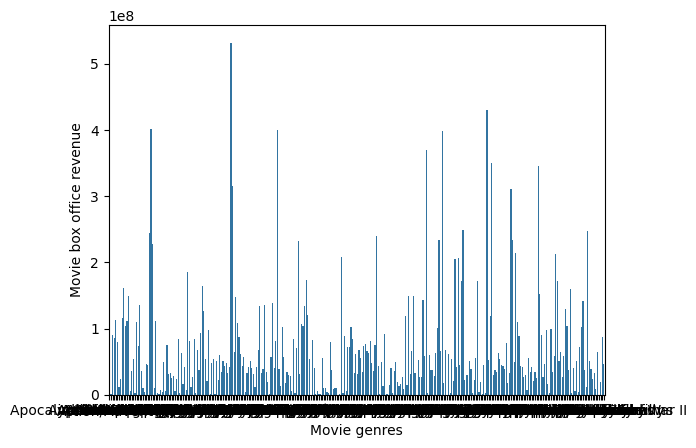

In [9]:
sns.barplot(x='Movie genres', y='Movie box office revenue', data=box_office_by_genre)

In [10]:
box_office_by_language = movies_languages.groupby('Movie languages')['Movie box office revenue'].agg('mean').reset_index()
box_office_by_language

,Movie languages,Movie box office revenue
0,Aboriginal Malay languages,1.629449e+08
1,Afrikaans Language,1.023347e+08
2,Albanian language,1.455435e+08
3,Algonquin Language,3.053601e+07
4,American English,3.316171e+07
...,...,...
138,Wolof Language,1.298727e+07
139,Xhosa Language,2.506511e+08
140,Yiddish Language,3.398626e+07
141,Zulu Language,2.428868e+08


In [11]:
def search(langs, simple_langs):
    for lang in simple_langs:
        if lang[0] in langs:
            return lang[0]
    return langs

In [12]:
def filter(langs):
    if 'sign' in langs:
        return langs
    if 'language' in langs:
        langs.remove('language')
    return langs

In [13]:
def flatten(x):
    if isinstance(x, list):
        return " ".join(x)
    return x

In [14]:
def extract_languages(langs):
    langs = langs.apply(lambda x: x.lower().split())
    langs = langs.apply(lambda x: filter(x))
    unique = langs[langs.apply(lambda x: len(x) == 1)]
    langs = langs.apply(lambda x: search(x, unique))
    langs = langs.apply(lambda x: flatten(x))
    return langs

In [15]:
def clean_genres(genres):
    genres = genres.apply(lambda x: x.lower().split())
    genres = genres.apply(lambda x: filter(x))
    return genres

In [16]:
langs = extract_languages(movies_languages['Movie languages'])
movies_languages['Movie languages'] = langs
box_office_by_language = movies_languages.groupby(['Movie languages','Movie release date'])['Movie box office revenue'].agg('mean').reset_index()
r = box_office_by_language.sort_values(by='Movie box office revenue', ascending=False)
r

,Movie languages,Movie release date,Movie box office revenue
1007,swedish,1997,1.224646e+09
1119,zulu,1994,9.515838e+08
1097,xhosa,1994,9.515838e+08
989,swahili,1994,9.515838e+08
128,chinese,2004,7.837663e+08
...,...,...,...
1120,zulu,2003,3.165100e+04
2,afrikaans,2003,3.165100e+04
725,papiamento,1999,3.047100e+04
114,chechen,2005,1.931700e+04


<Axes: xlabel='Movie release date', ylabel='Movie box office revenue'>

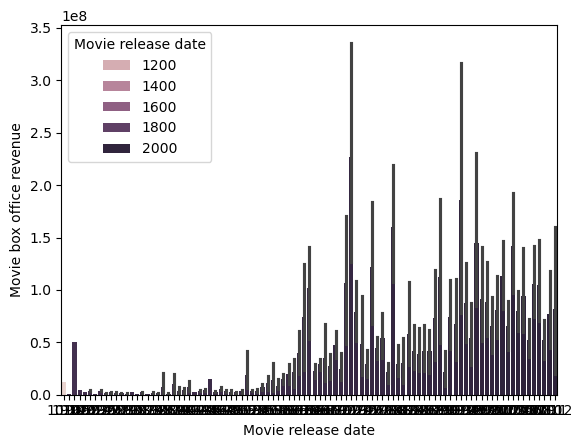

In [36]:
sns.barplot(x='Movie release date', y='Movie box office revenue', data=box_office_by_language, hue='Movie release date')

In [10]:
query = "Ghosts of Mars"
api_key = "f8771939d394040dc6b642d4dc497043"
url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={query}&language=en-US&page=1"

In [12]:
response = requests.get(url)
data = response.json()['results'][0]
id = data['id']
print(id)

10016


In [34]:
details_url = f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}"
details_response = requests.get(details_url).json()

print(details_response)

{'adult': False, 'backdrop_path': '/anSbunnEMI0TSmizqUSRACoe18l.jpg', 'belongs_to_collection': None, 'budget': 28000000, 'genres': [{'id': 28, 'name': 'Action'}, {'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}], 'homepage': 'http://www.theofficialjohncarpenter.com/ghost-of-mars/', 'id': 10016, 'imdb_id': 'tt0228333', 'origin_country': ['US'], 'original_language': 'en', 'original_title': 'Ghosts of Mars', 'overview': 'In 2176, a Martian police unit is sent to pick up a highly dangerous criminal at a remote mining post. Upon arrival, the cops find the post deserted and something far more dangerous than any criminal — the original inhabitants of Mars, hellbent on getting their planet back.', 'popularity': 20.332, 'poster_path': '/i2zztssCIbahGES1fdfWFmDXian.jpg', 'production_companies': [{'id': 51312, 'logo_path': None, 'name': 'Animationwerks', 'origin_country': ''}, {'id': 3287, 'logo_path': '/bz6GbCQQXGNE56LTW9dwgksW0Iw.png', 'name': 'Screen Gems', 'origin_country'